In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import warnings

warnings.filterwarnings(action='ignore')
%matplotlib inline

# 한글 폰트 설정
plt.rcParams["font.family"] = "Malgun Gothic"  # Windows (맑은 고딕)
# 마이너스 기호 깨짐 방지
plt.rcParams["axes.unicode_minus"] = False

## **1. 데이터 출처 / 데이터 불러오기**
-  [kaggle_Health Insurance Cross Sell Prediction 🏠 🏥](https://www.kaggle.com/datasets/anmolkumar/health-insurance-cross-sell-prediction/data)
- 데이터 선정 이유: 보험 분야에서의 머신러닝 활용을 직접 해보고자!

### **분석 목적/인사이트 설명**
- 목적: 건강 보험 가입 고객이 차량 보험에 가입할 가능성(Response=1)을 예측
    - 고객특성(연령, 운전면허 보유 여부, 차량 보유여부)와 차량특성(차량연식, 손상경험)을 이용하여 차량 보험 가능성 예측
- 문제 유형: 이진 분류(Binary Classification) 문제
- 얻을 수 있는 인사이트   
    1) 고객 특성과 보험 가입 가능성 간의 관계
        - 연령(Age)과 가입 의향(Response)의 관계
        - 운전면허 보유 여부(Driving_License)
        - 기존 차량 보험 여부(Previously_Insured)
    2) 차량 관련 정보와 가입 의향 분석
        - 차량 연식(Vehicle_Age)과 가입률
        - 사고 경험(Vehicle_Damage)과 가입 의향

In [2]:
train = pd.read_csv('./data/train.csv')
test = pd.read_csv('./data/test.csv')

In [3]:
train.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


In [4]:
test.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage
0,381110,Male,25,1,11.0,1,< 1 Year,No,35786.0,152.0,53
1,381111,Male,40,1,28.0,0,1-2 Year,Yes,33762.0,7.0,111
2,381112,Male,47,1,28.0,0,1-2 Year,Yes,40050.0,124.0,199
3,381113,Male,24,1,27.0,1,< 1 Year,Yes,37356.0,152.0,187
4,381114,Male,27,1,28.0,1,< 1 Year,No,59097.0,152.0,297


## **2. 기초 통계량 확인**

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 381109 entries, 0 to 381108
Data columns (total 12 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    381109 non-null  int64  
 1   Gender                381109 non-null  object 
 2   Age                   381109 non-null  int64  
 3   Driving_License       381109 non-null  int64  
 4   Region_Code           381109 non-null  float64
 5   Previously_Insured    381109 non-null  int64  
 6   Vehicle_Age           381109 non-null  object 
 7   Vehicle_Damage        381109 non-null  object 
 8   Annual_Premium        381109 non-null  float64
 9   Policy_Sales_Channel  381109 non-null  float64
 10  Vintage               381109 non-null  int64  
 11  Response              381109 non-null  int64  
dtypes: float64(3), int64(6), object(3)
memory usage: 34.9+ MB


In [6]:
int_var = train[['id', 'Age', 'Previously_Insured', 'Annual_Premium', 'Vintage']]
obj_var = train[['Gender', 'Vehicle_Age', 'Vehicle_Damage']]
obj_var2 = [['Policy_Sales_Channel', 'Driving_License', 'Previously_Insured']]

### 수치형 변수(int, float)

In [7]:
int_var.describe()

,id,Age,Previously_Insured,Annual_Premium,Vintage
count,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000
mean,190555.000000,38.822584,0.458210,30564.389581,154.347397
std,110016.836208,15.511611,0.498251,17213.155057,83.671304
min,1.000000,20.000000,0.000000,2630.000000,10.000000
25%,95278.000000,25.000000,0.000000,24405.000000,82.000000
50%,190555.000000,36.000000,0.000000,31669.000000,154.000000
75%,285832.000000,49.000000,1.000000,39400.000000,227.000000
max,381109.000000,85.000000,1.000000,540165.000000,299.000000


### 범주형 변수(object)

In [8]:
int_var = train[['id', 'Age', 'Annual_Premium', 'Vintage', 'Response']]
obj_var = train[['Gender', 'Vehicle_Age', 'Vehicle_Damage', 'Policy_Sales_Channel', 'Region_Code', 'Driving_License', 'Previously_Insured']]
for i in range(obj_var.shape[1]):
    category = np.unique(obj_var.iloc[:,i])
    print(f'{obj_var.columns[i]}: {category} ')

Gender: ['Female' 'Male'] 
Vehicle_Age: ['1-2 Year' '< 1 Year' '> 2 Years'] 
Vehicle_Damage: ['No' 'Yes'] 
Policy_Sales_Channel: [  1.   2.   3.   4.   6.   7.   8.   9.  10.  11.  12.  13.  14.  15.
  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.  28.  29.
  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.  41.  42.  43.
  44.  45.  46.  47.  48.  49.  50.  51.  52.  53.  54.  55.  56.  57.
  58.  59.  60.  61.  62.  63.  64.  65.  66.  67.  68.  69.  70.  71.
  73.  74.  75.  76.  78.  79.  80.  81.  82.  83.  84.  86.  87.  88.
  89.  90.  91.  92.  93.  94.  95.  96.  97.  98.  99. 100. 101. 102.
 103. 104. 105. 106. 107. 108. 109. 110. 111. 112. 113. 114. 115. 116.
 117. 118. 119. 120. 121. 122. 123. 124. 125. 126. 127. 128. 129. 130.
 131. 132. 133. 134. 135. 136. 137. 138. 139. 140. 143. 144. 145. 146.
 147. 148. 149. 150. 151. 152. 153. 154. 155. 156. 157. 158. 159. 160.
 163.] 
Region_Code: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 

In [9]:
obj_var.describe()

,Policy_Sales_Channel,Region_Code,Driving_License,Previously_Insured
count,381109.000000,381109.000000,381109.000000,381109.000000
mean,112.034295,26.388807,0.997869,0.458210
std,54.203995,13.229888,0.046110,0.498251
min,1.000000,0.000000,0.000000,0.000000
25%,29.000000,15.000000,1.000000,0.000000
50%,133.000000,28.000000,1.000000,0.000000
75%,152.000000,35.000000,1.000000,1.000000
max,163.000000,52.000000,1.000000,1.000000


### 변수 간단요약
<img src="https://github.com/leehj2586/Epoch/blob/main/Task/img/변수요약.png?raw=true" width="500">


## **3. 데이터 전처리**
- 결측치 X
- 연간 보험료 이상치 존재 -> 상한 및 하한 지정해서 이상치 제거
- 범주형 변수 라벨 인코딩
    - 연식은 3개로 분류: 크고 낮음이 존재
    - 나머지 두 변수: 이진 분류

- 보험 가입자가 적은 편향된 데이터

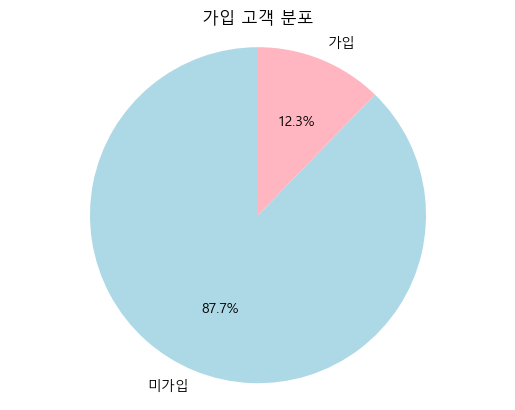

In [12]:
# 0과 1의 비율을 계산
sizes = [len(df[df['Response']==0]), len(df[df['Response']==1])]
labels = ['미가입', '가입']
# 원그래프 그리기ㅋㅋㅋ
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, colors=['lightblue', 'lightpink'])
plt.title('가입 고객 분포')
plt.axis('equal')  # 원이 왜곡되지 않도록
plt.show()

- 이상치 제거
  - 이상치 갯수가 많은 비율을 차지하지 않고, 너무 크게 치우친 값이라 삭제 

In [13]:
cost = df["Annual_Premium"]
q1 = cost.quantile(0.25)
q3 = cost.quantile(0.75)

IQR = q3 - q1

lower = q1 - 1.5 * IQR
upper = q3 + 1.5 * IQR

outliers = df[(cost < lower) | (cost > upper)]
print(f'lower bound : {lower}, upper bound: {upper} \n 이상치 개수: {len(outliers)}, 이상치 비율 = {round(len(outliers)/len(df), 2)}')

# 이상치 제거 : 상한 및 하한 설정
filtered = df[(cost >= lower) & (cost <= upper)]

lower bound : 1912.5, upper bound: 61892.5 
 이상치 개수: 10320, 이상치 비율 = 0.03


In [10]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()

# 범주형 데이터 라벨인코딩
df = train.copy()
df['Gender'] = encoder.fit_transform(df['Gender'])
df['Vehicle_Age'] = encoder.fit_transform(df['Vehicle_Age'])
df['Vehicle_Damage'] = encoder.fit_transform(df['Vehicle_Damage'])

## **4. EDA - 변수 간관계 분석 및 시각화**

<img src="https://github.com/leehj2586/Epoch/blob/main/Task/img/Week2_칼럼정리.png?raw=true" width="500">

### 1) 수치형 변수: 나이, 연간 보험료, 고객이 보험사와 함께한 일 수

- 나이
  - 연령대가 다양하게 나타남 -> 20대가 가장 많긴 함.
  - 인원수가 아닌, 가입 여부에 따른 연령대의 분포 모양만 확인해보기

Text(0.5, 1.0, '고객의 연령대 분포')

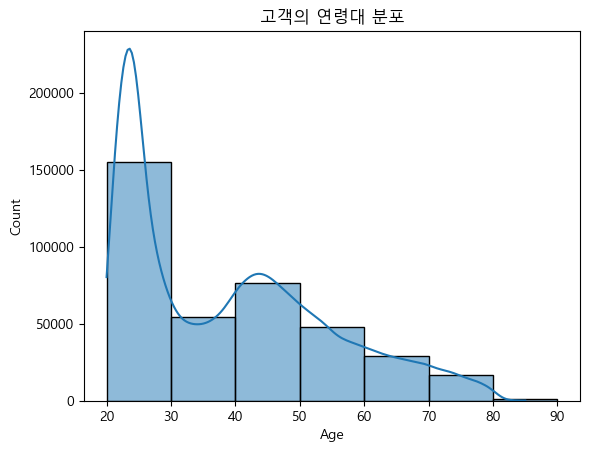

In [99]:
bins = [20, 30, 40, 50, 60, 70, 80, 90]
sns.histplot(train['Age'], bins = bins, kde=True)
plt.title("고객의 연령대 분포")

- 연간 보험료
  - 이상치가 10320개로, 전체의 36%를 차지 -> 박스플랏의 분포를 정확히 판단하기 어려움
  - 이상치를 제외한 데이터로 boxplot을 그려봄
    - 오른쪽으로 꼬리가 긴편, 봉우리가 2개가 나타난 부분 확인 필요

lower bound : 1912.5, upper bound: 61892.5 
 이상치 개수: 10320, 이상치 비율 = 36.93


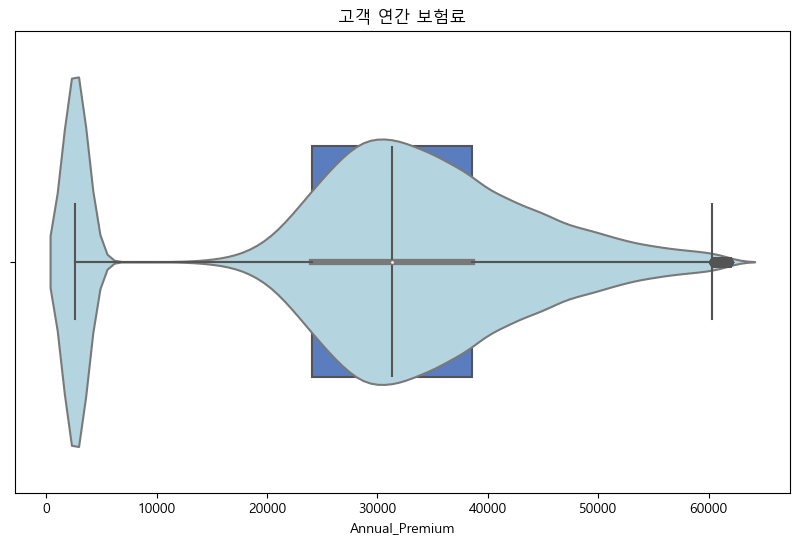

In [166]:
cost = train["Annual_Premium"]
q1 = cost.quantile(0.25)
q3 = cost.quantile(0.75)

IQR = q3-q1

lower = q1 - 1.5*IQR
upper = q3 + 1.5*IQR

outliers = train[(cost < lower) | (cost > upper)]
print(f'lower bound : {lower}, upper bound: {upper} \n 이상치 개수: {len(outliers)}, 이상치 비율 = {round(len(train)/len(outliers), 2)}')


filtered = train[(cost>=lower)&(cost<=upper)]

plt.figure(figsize = (10,6))

violin = sns.violinplot(x=filtered["Annual_Premium"], alpha = 0.3, color='lightblue')

''' 투명도 조절이 안된다.. 왜지...
for pc in violin.collections:
    if isinstance(pc, plt.Polygon):
        pc.set_alpha(0.3)
'''
sns.boxplot(x=filtered["Annual_Premium"], width=0.5)
plt.title("고객 연간 보험료")
plt.show()


- 회원 지속일 수 (기존 Vintage)
  - 일수로 나타낸 것이 가시성이 좋지 않다고 판단되어 30으로 나눠 개월 수 데이터로 바꾸어 그래프를 그려봄 
- 회원 지속개월 수 (파생 Vintage_Month)
  - 1개월 이하 회원 데이터는 많지 않은편
  - 2개월~10개월 회원수는 비슷하게 분포 

In [102]:
train["Vintage_Month"] = round(train['Vintage']/30,1)

(22500.0, 42494.55)

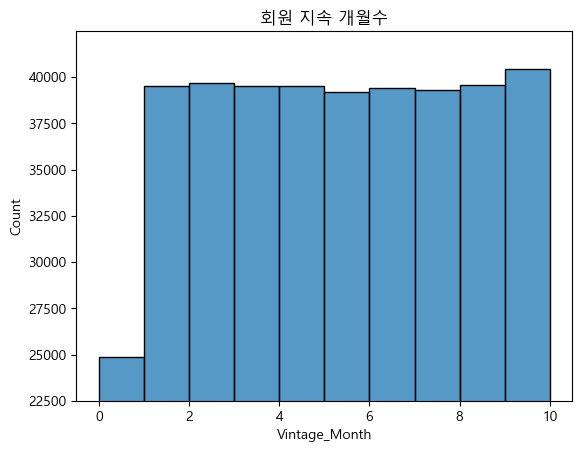

In [103]:
bins = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
sns.histplot(train["Vintage_Month"], bins = bins)
plt.title("회원 지속 개월수")
plt.ylim(22500, )

- 가입 여부에 따른 수치형 변수의 변화
  -> 각 변수별 코멘트는 아래 표에 정리 

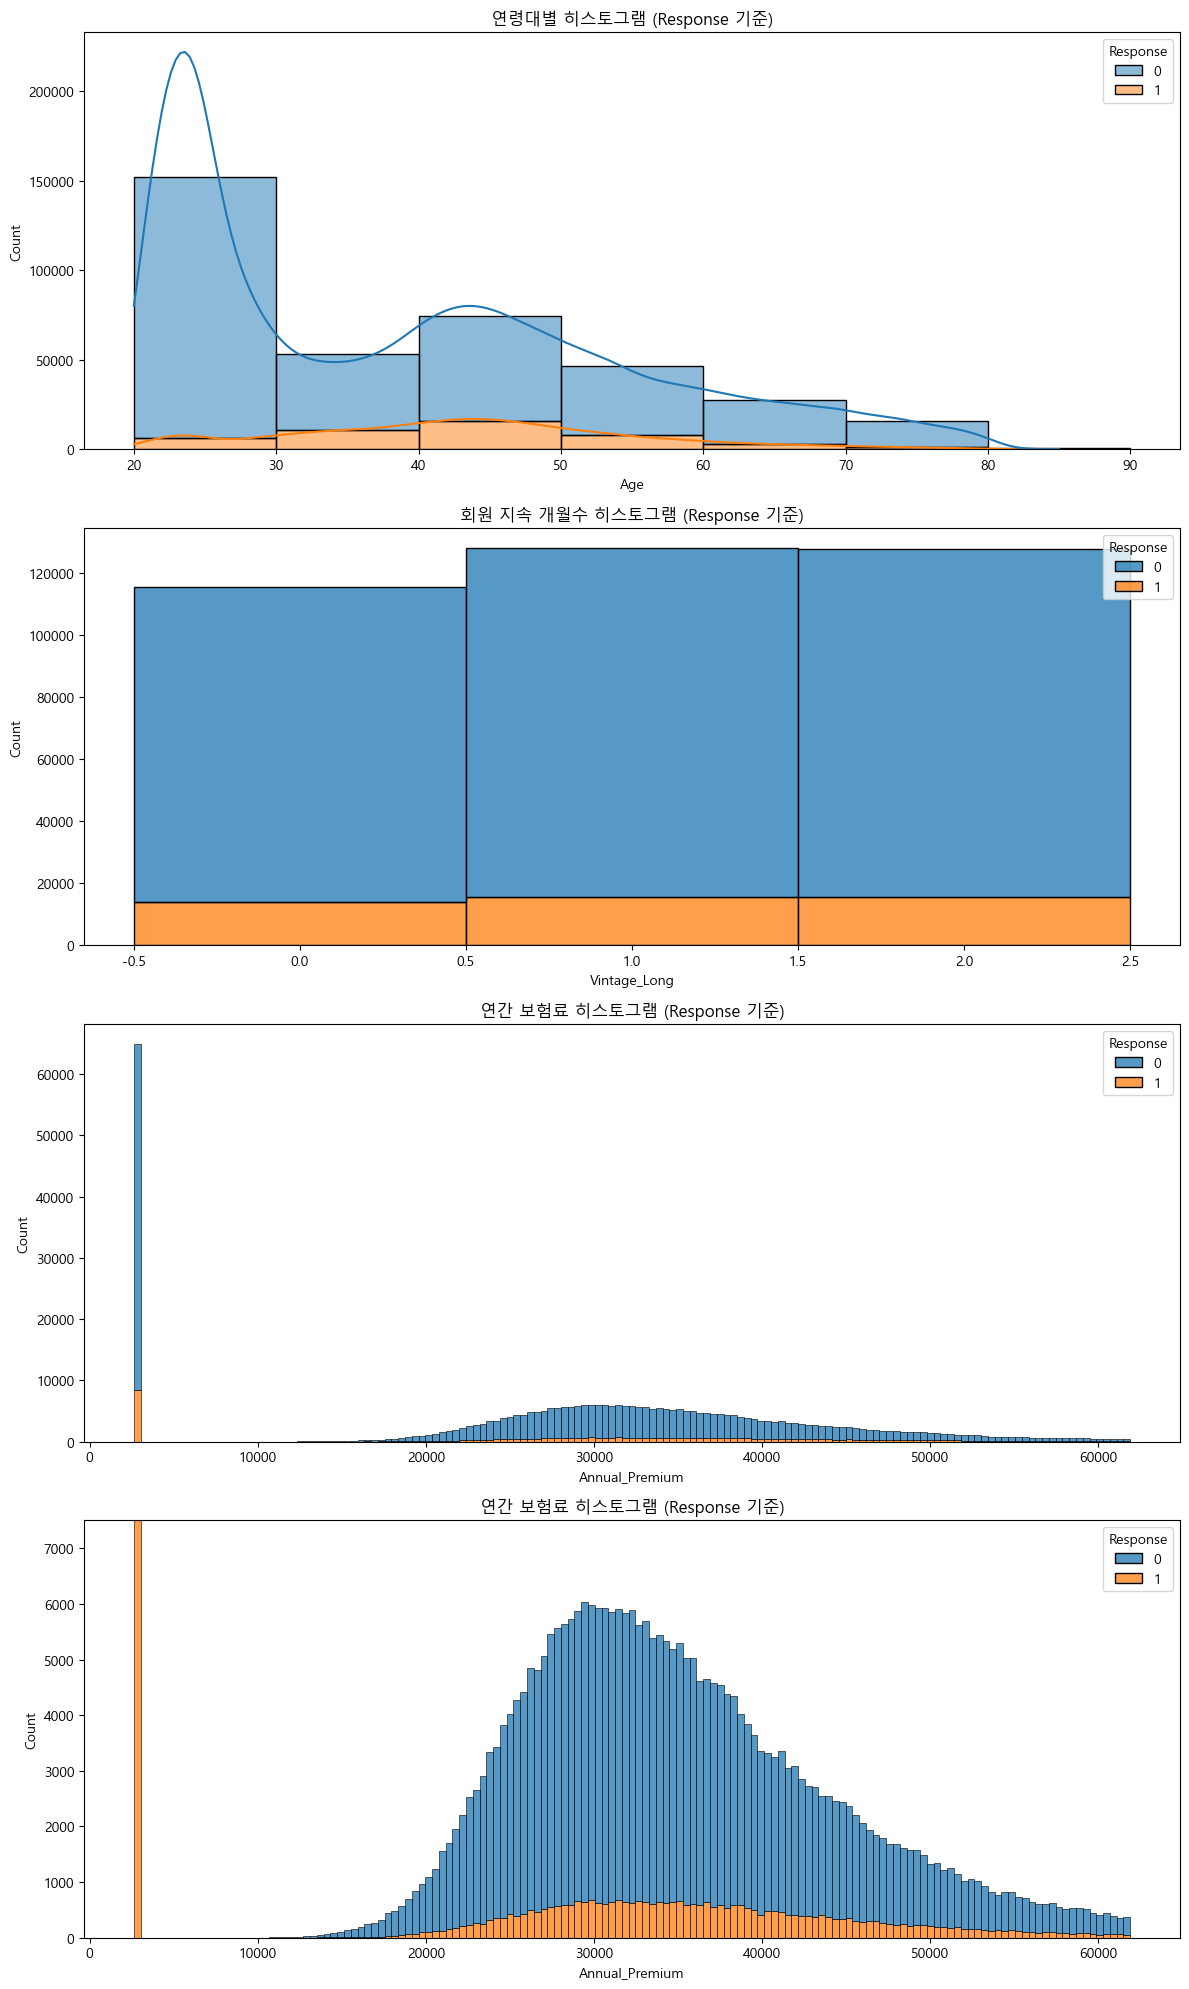

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns

bin1 = [20, 30, 40, 50, 60, 70, 80, 90]
bin2 = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

fig, axes = plt.subplots(4, 1, figsize=(12, 20))  # 4개의 행으로 구성

# 연령대별 히스토그램 (Response 기준 구분)
sns.histplot(data=filtered, x='Age', hue='Response', kde=True, bins=bin1, ax=axes[0], multiple='stack')
axes[0].set_title('연령대별 히스토그램 (Response 기준)')

# 회원 지속 개월수 히스토그램
sns.histplot(data=filtered, x='Vintage_Long', hue='Response', bins=bin2, ax=axes[1], multiple='stack')
axes[1].set_title('회원 지속 개월수 히스토그램 (Response 기준)')

# 연간 보험료 히스토그램
sns.histplot(data=filtered, x='Annual_Premium', hue='Response', ax=axes[2], multiple='stack')
axes[2].set_title('연간 보험료 히스토그램 (Response 기준)')

# 연간 보험료 히스토그램(상세)
sns.histplot(data=filtered, x='Annual_Premium', hue='Response', ax=axes[3], multiple='stack')
axes[3].set_title('연간 보험료 히스토그램 (Response 기준)')
axes[3].set_ylim(0, 7500)

# 전체 레이아웃 조정
plt.tight_layout()
plt.show()


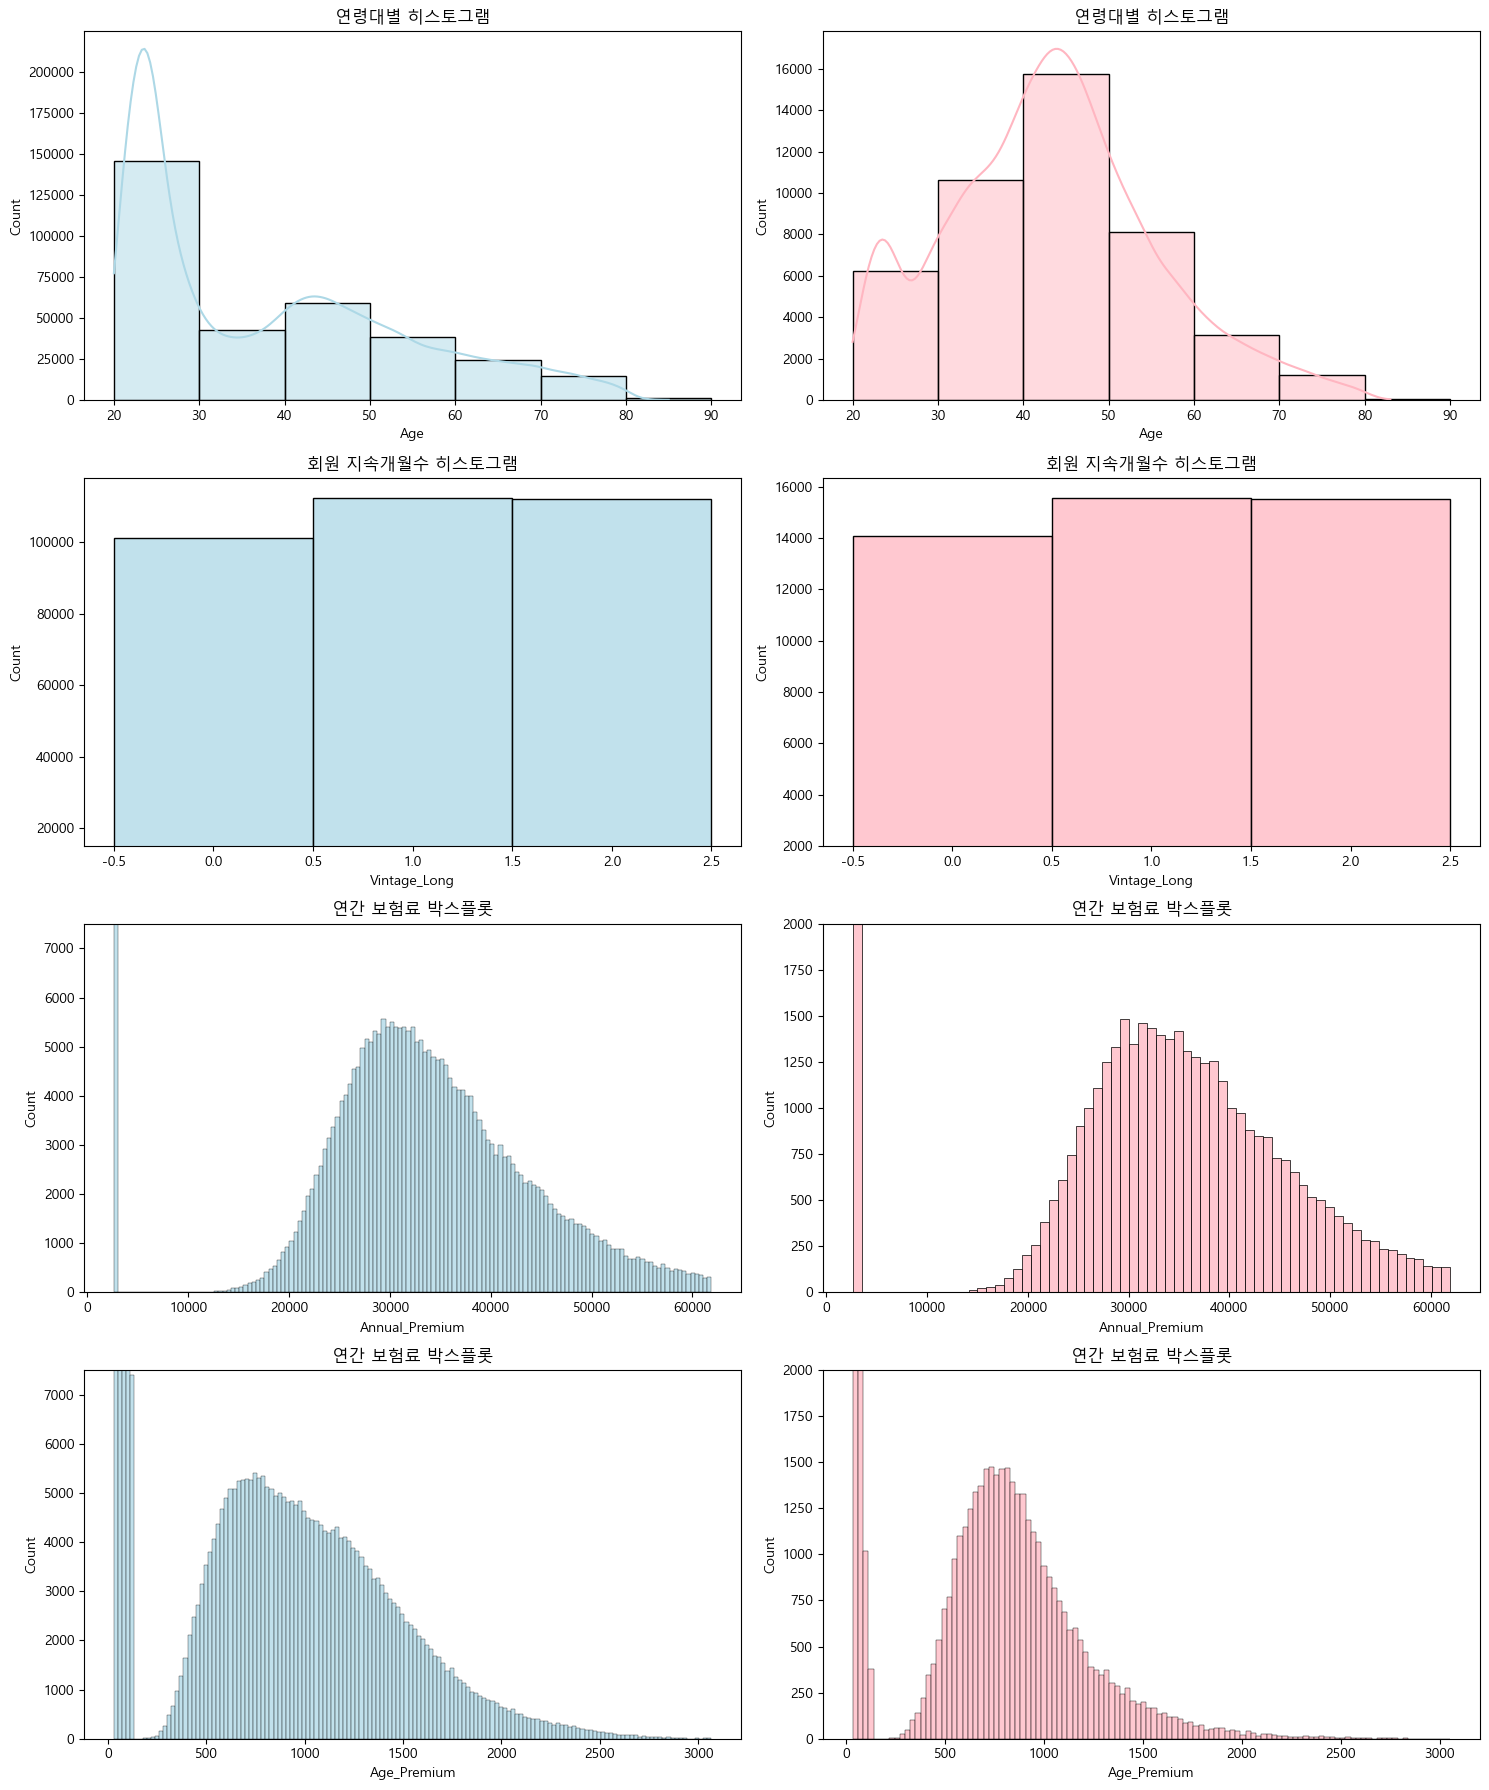

In [22]:
bin1 = [20, 30, 40, 50, 60, 70, 80, 90]
bin2 = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
response_values = filtered['Response'].unique()

fig, axes = plt.subplots(4, 2, figsize=(15, 18))

# 연령 히스토그램
sns.histplot(filtered[filtered['Response'] == 0]['Age'], kde=True, bins=bin1, ax=axes[0, 0], label='Response 0', color = 'lightblue')
axes[0, 0].set_title('연령대별 히스토그램')

sns.histplot(filtered[filtered['Response'] == 1]['Age'], kde=True, bins=bin1, ax=axes[0, 1], label='Response 1', color = 'lightpink')
axes[0, 1].set_title('연령대별 히스토그램')

# 회원 지속 개월 수 박스플롯
sns.histplot(filtered[filtered['Response'] == 0]['Vintage_Long'], bins=bin2, ax=axes[1, 0], label='Response 0', color = 'lightblue')
axes[1, 0].set_title('회원 지속개월수 히스토그램')
axes[1, 0].set_ylim(15000,)

sns.histplot(filtered[filtered['Response'] == 1]['Vintage_Long'], bins=bin2, ax=axes[1, 1], label='Response 1', color = 'lightpink')
axes[1, 1].set_title('회원 지속개월수 히스토그램')
axes[1, 1].set_ylim(2000,)

# 연간 보험료 박스플롯
sns.histplot(filtered[filtered['Response'] == 0]['Annual_Premium'], ax=axes[2, 0], label='Response 0', color = 'lightblue')
axes[2, 0].set_title('연간 보험료 박스플롯')
axes[2, 0].set_ylim(bottom=None, top=7500)

sns.histplot(filtered[filtered['Response'] == 1]['Annual_Premium'], ax=axes[2, 1], label='Response 1', color = 'lightpink')
axes[2, 1].set_title('연간 보험료 박스플롯')
axes[2, 1].set_ylim(bottom=None, top=2000)

# 연간 보험료 박스플롯
sns.histplot(filtered[filtered['Response'] == 0]['Age_Premium'], ax=axes[3, 0], label='Response 0', color = 'lightblue')
axes[3, 0].set_title('연간 보험료 박스플롯')
axes[3, 0].set_ylim(bottom=None, top=7500)

sns.histplot(filtered[filtered['Response'] == 1]['Age_Premium'], ax=axes[3, 1], label='Response 1', color = 'lightpink')
axes[3, 1].set_title('연간 보험료 박스플롯')
axes[3, 1].set_ylim(bottom=None, top=2000)

# 레이아웃 자동 조정
plt.tight_layout()
plt.show()

### 2) 범주형 변수: 성별, 차량 연식, 차량 손상여부

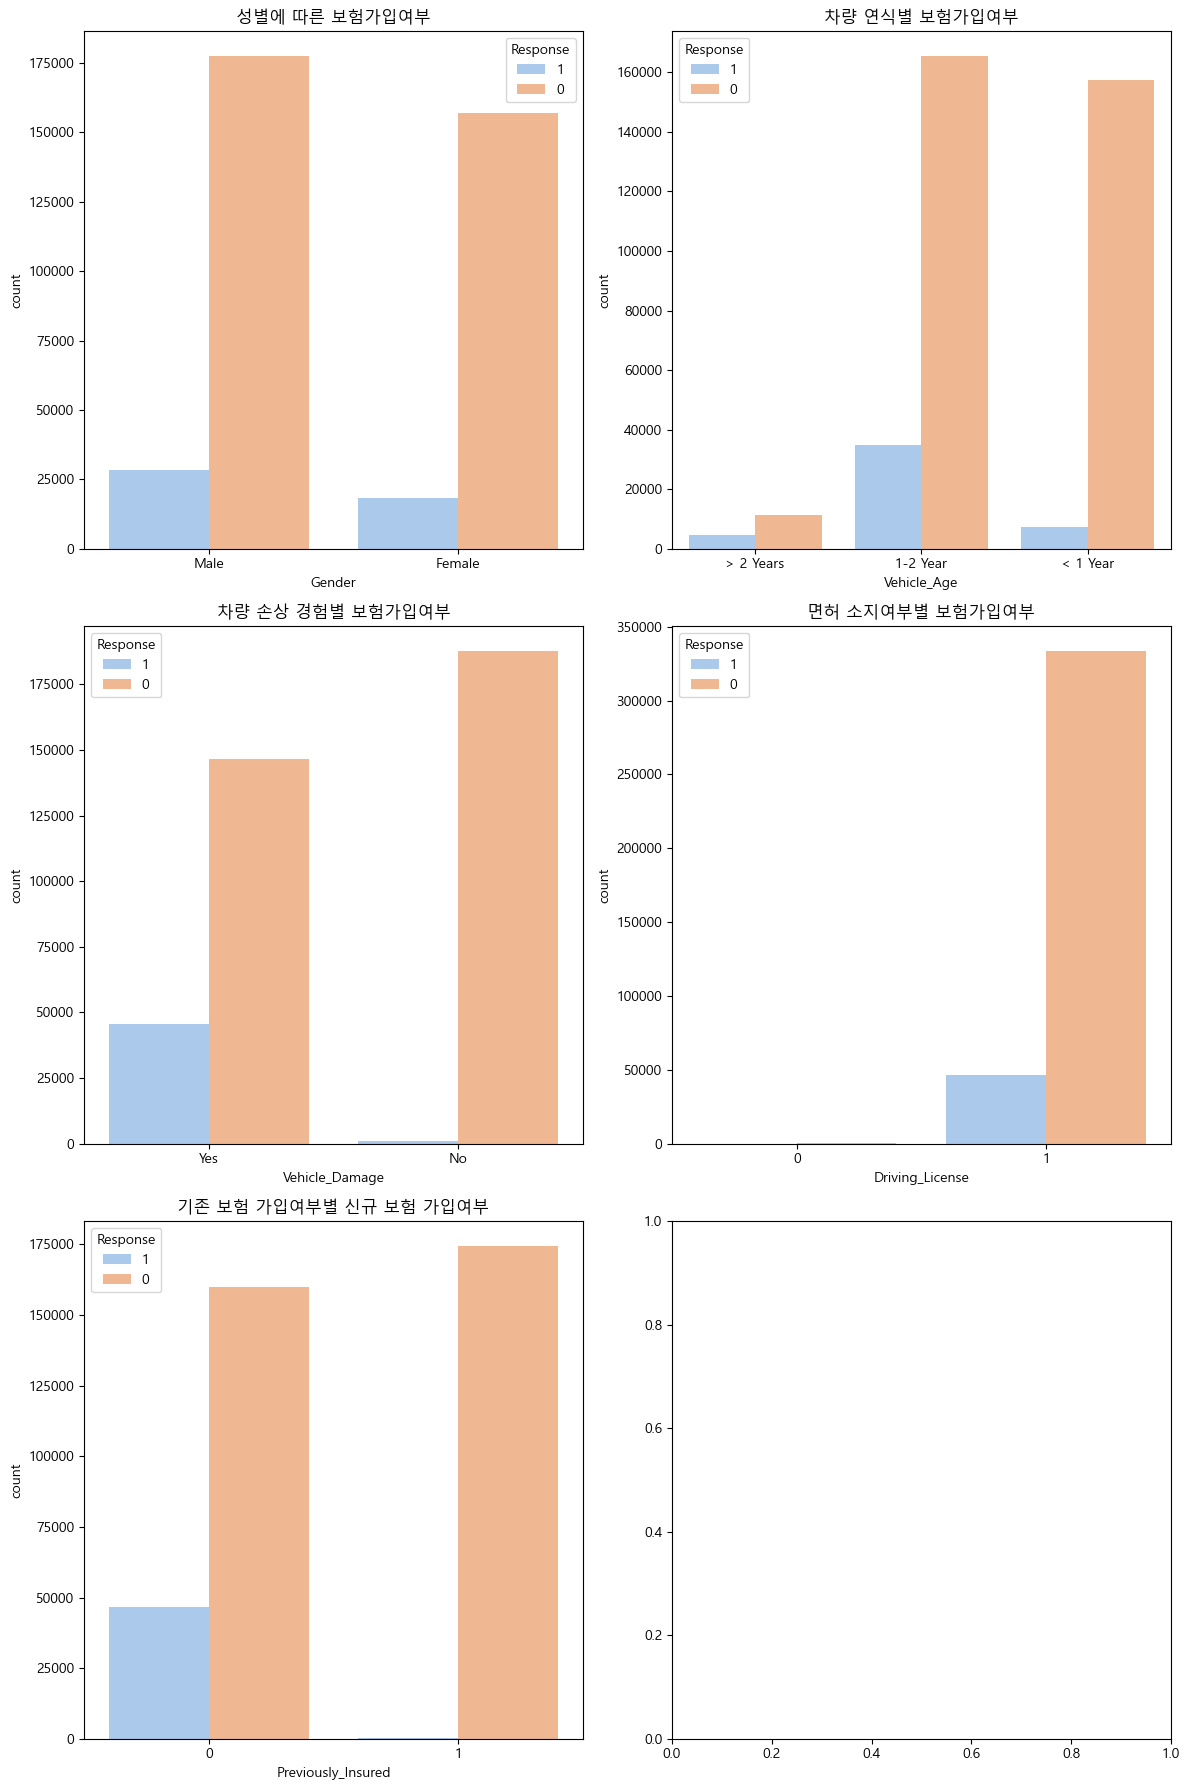

In [41]:
filtered['Response'] = filtered['Response'].astype(str)

# 그래프 크기 설정
fig, axes = plt.subplots(3, 2, figsize=(12, 18))

# 성별 보험가입 여부
sns.countplot(data=filtered, x='Gender', hue='Response', palette='pastel', ax=axes[0, 0])
axes[0, 0].set_title('성별에 따른 보험가입여부')

# 차량 연식별 보험가입 여부
sns.countplot(data=filtered, x='Vehicle_Age', hue='Response', palette='pastel', ax=axes[0, 1])
axes[0, 1].set_title('차량 연식별 보험가입여부')

# 차량 손상 경험별 보험가입 여부
sns.countplot(data=filtered, x='Vehicle_Damage', hue='Response', palette='pastel', ax=axes[1, 0])
axes[1, 0].set_title('차량 손상 경험별 보험가입여부')

# 면허소지여부별 보험가입여부
sns.countplot(data=filtered, x='Driving_License', hue='Response', palette='pastel', ax=axes[1, 1])
axes[1, 1].set_title('면허 소지여부별 보험가입여부')

# 기존 보험 가입여부별 신규 보험 가입여부
sns.countplot(data=filtered, x='Previously_Insured', hue='Response', palette='pastel', ax=axes[2, 0])
axes[2, 0].set_title('기존 보험 가입여부별 신규 보험 가입여부')

plt.tight_layout()  # 그래프 간격 자동 조정
plt.show()


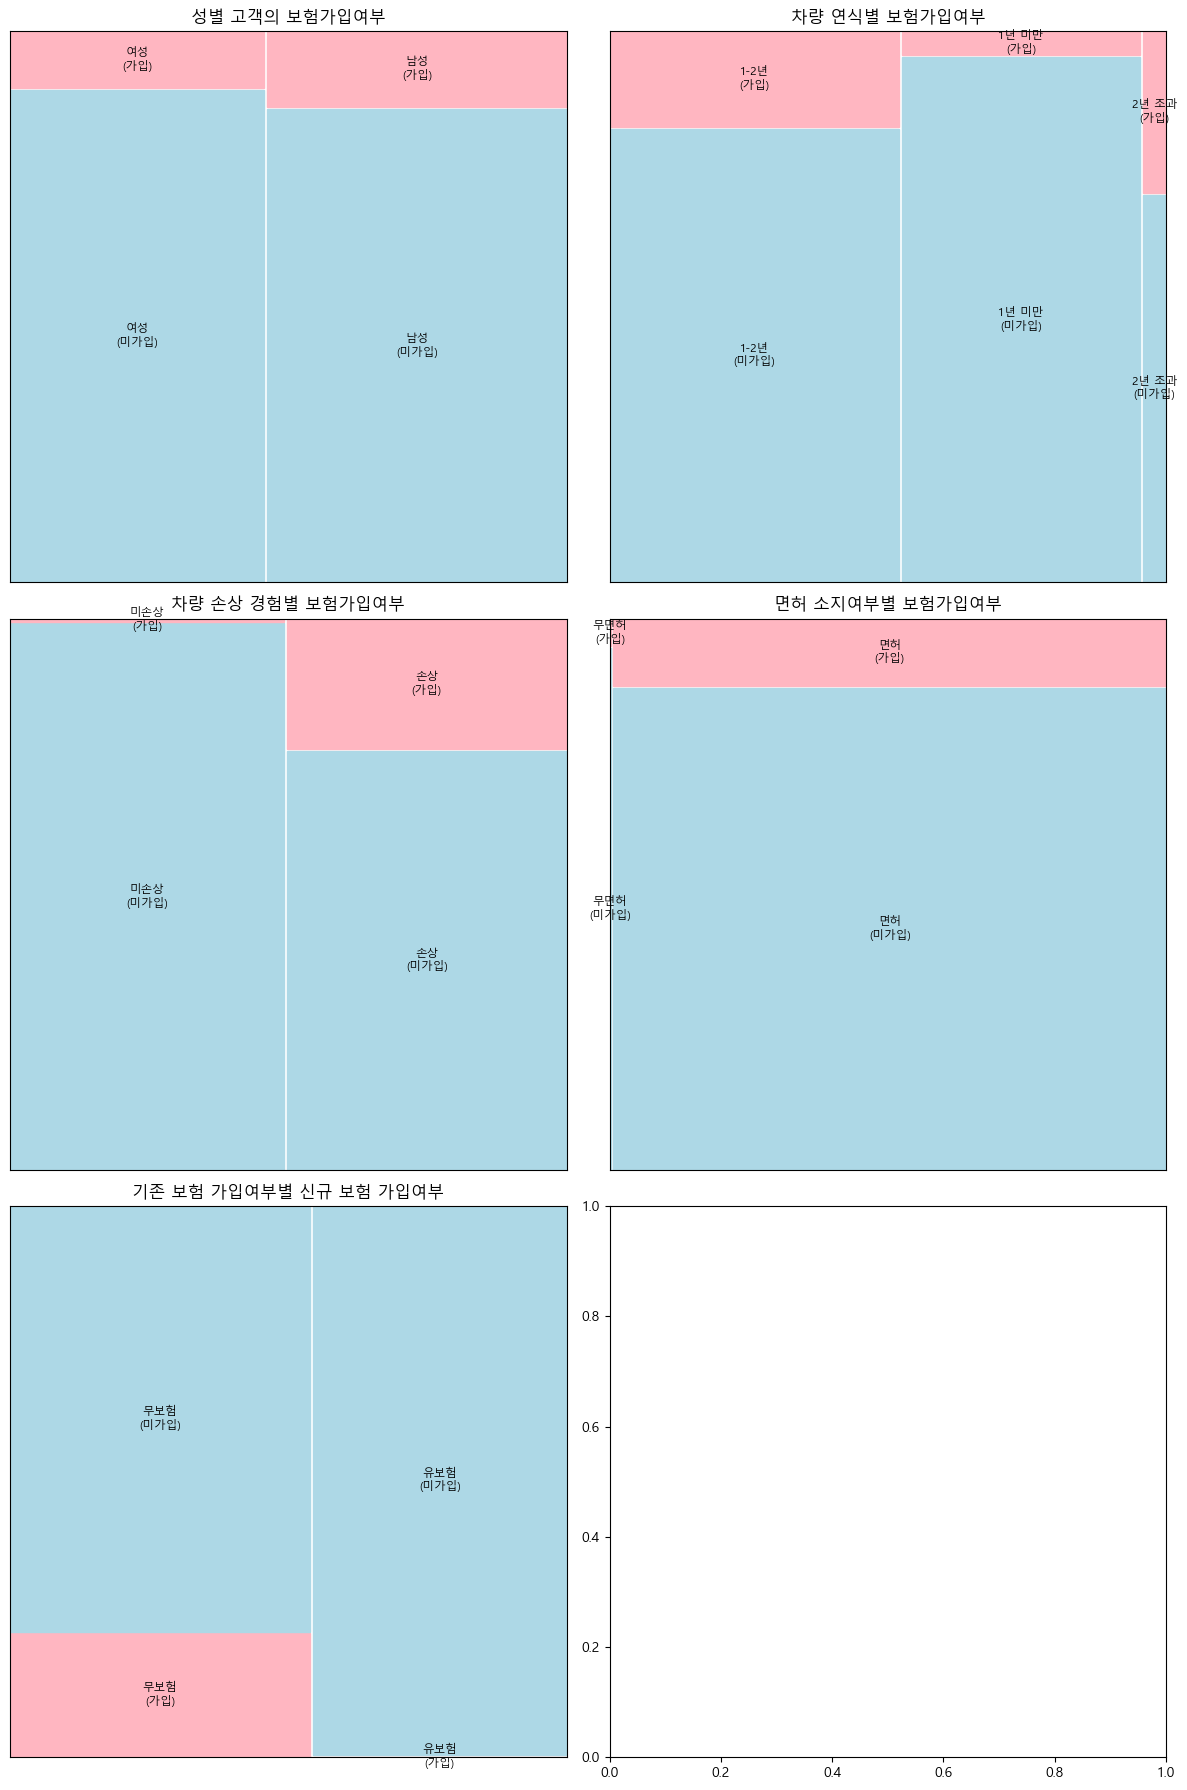

In [175]:
from statsmodels.graphics.mosaicplot import mosaic
import matplotlib.pyplot as plt

fig, axes = plt.subplots(3, 2, figsize=(12, 18))  # 3행 1열로 서브플롯 설정

# 성별 보험가입 여부 그래프
props = lambda key: {'color': 'lightpink' if '1' in key else 'lightblue'}
labelizer = lambda k: {('Female','1'): '여성\n(가입)', ('Female','0'): '여성\n(미가입)',
                        ('Male','1'): '남성\n(가입)', ('Male', '0'): '남성\n(미가입)'}[k]

mosaic(train.sort_values('Gender'),
       ['Gender', 'Response'],
       properties=props,
       labelizer=labelizer,
       axes_label=False,
       ax=axes[0,0])  # 첫 번째 서브플롯에 그래프 그리기
axes[0,0].set_title('성별 고객의 보험가입여부')

# 차량 연식별 보험가입 여부 그래프
color_map = {
    ('1-2 Year', '1'): 'lightpink',
    ('1-2 Year', '0'): 'lightblue',
    ('< 1 Year', '1'): 'lightpink',
    ('< 1 Year', '0'): 'lightblue',
    ('> 2 Years', '1'): 'lightpink',
    ('> 2 Years', '0'): 'lightblue'
}

props = lambda key: {'color': color_map[key]}

labelizer = lambda k: {
    ('1-2 Year', '1'): '1-2년\n(가입)',
    ('1-2 Year', '0'): '1-2년\n(미가입)',
    ('< 1 Year', '1'): '1년 미만\n(가입)',
    ('< 1 Year', '0'): '1년 미만\n(미가입)',
    ('> 2 Years', '1'): '2년 초과\n(가입)',
    ('> 2 Years', '0'): '2년 초과\n(미가입)'
}[k]

mosaic(train.sort_values('Vehicle_Age'),
       ['Vehicle_Age', 'Response'],
       properties=props,
       labelizer=labelizer,
       axes_label=False,
       ax=axes[0,1])  # 두 번째 서브플롯에 그래프 그리기
axes[0,1].set_title('차량 연식별 보험가입여부')

# 차량 손상 경험별 보험가입 여부 그래프
props = lambda key: {'color': 'lightpink' if '1' in key else 'lightblue'}
labelizer = lambda k: {('No','1'): '미손상\n(가입)', ('No','0'): '미손상\n(미가입)',
                        ('Yes','1'): '손상\n(가입)', ('Yes', '0'): '손상\n(미가입)'}[k]

mosaic(train.sort_values('Vehicle_Damage'),
       ['Vehicle_Damage', 'Response'],
       properties=props,
       labelizer=labelizer,
       axes_label=False,
       ax=axes[1,0])  # 세 번째 서브플롯에 그래프 그리기
axes[1,0].set_title('차량 손상 경험별 보험가입여부')

# 면허소지여부별 보험가입여부
props = lambda key: {'color': 'lightpink' if key[1] == '1' else 'lightblue'}  # 가입일 때 핑크, 미가입일 때 블루
labelizer = lambda k: {('0','1'): '무면허\n(가입)', ('0','0'): '무면허\n(미가입)',
                        ('1','1'): '면허\n(가입)', ('1', '0'): '면허\n(미가입)'}[k]

mosaic(train.sort_values('Driving_License'),
       ['Driving_License', 'Response'],
       properties=props,
       labelizer=labelizer,
       axes_label=False,
       ax=axes[1,1])  # 세 번째 서브플롯에 그래프 그리기
axes[1,1].set_title('면허 소지여부별 보험가입여부')

# 기존의 보험 가입여부별 신규 보험 가입여부
props = lambda key: {'color': 'lightpink' if key[1] == '1' else 'lightblue'}  # 가입일 때 핑크, 미가입일 때 블루
labelizer = lambda k: {('0','1'): '무보험\n(가입)', ('0','0'): '무보험\n(미가입)',
                        ('1','1'): '유보험\n(가입)', ('1', '0'): '유보험\n(미가입)'}[k]

mosaic(train.sort_values('Previously_Insured'),
       ['Previously_Insured', 'Response'],
       properties=props,
       labelizer=labelizer,
       axes_label=False,
       ax=axes[2,0])  # 세 번째 서브플롯에 그래프 그리기
axes[2,0].set_title('기존 보험 가입여부별 신규 보험 가입여부')

plt.tight_layout()  # 그래프 간격 자동 조정
plt.show()



## 시각화 분석 결과 요약
<img src="https://github.com/leehj2586/Epoch/blob/main/Task/img/Week2_칼럼정리.png?raw=true" width="500"> tps://agent.wrtn.ai/5xb91lttps://agent.wrtn.ai/5xb91l

## **5. 피처 엔지니어링**
- 새로운 파생변수
|변수명|정의| 설명 |
|----------|------------------------|----------------------------------------------|
|Age_Premium|Annual_Premium/Age <br> 보험료 대비 나이 비율| - 나이에 따른 보험료 변화 경향을 파악하기 위한 변수 <br> - 나이가 많을수록 보험료가 높은 보험료 자체의 특성상 두 변수를 함께 살펴볼 수 있는 변수의 필요성이 있다고 판단|
|Vintage_Year|고객 지속 기간| - 지속 일수를 기준으로 0-100일, 101-200일, 201-300일 3개의 범주로 구분 <br> - 지속 일수 데이터 자체로는 큰 의미가 없다고 생각|

In [14]:
filtered['Age_Premium'] = filtered['Annual_Premium']/filtered['Age']

In [15]:
bins = [0, 100, 200, 300]
labels = [0,1,2]
filtered['Vintage_Long'] = pd.cut(df['Vintage'], bins = bins, labels = labels, right = False)

In [16]:
filtered.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response,Age_Premium,Vintage_Long
0,1,1,44,1,28.0,0,2,1,40454.0,26.0,217,1,919.409091,2
1,2,1,76,1,3.0,0,0,0,33536.0,26.0,183,0,441.263158,1
2,3,1,47,1,28.0,0,2,1,38294.0,26.0,27,1,814.765957,0
3,4,1,21,1,11.0,1,1,0,28619.0,152.0,203,0,1362.809524,2
4,5,0,29,1,41.0,1,1,0,27496.0,152.0,39,0,948.137931,0


- 표준화

In [17]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaled = filtered.copy()
scaled[['Age', 'Annual_Premium', 'Vintage', 'Age_Premium']] = scaler.fit_transform(scaled[['Age', 'Annual_Premium', 'Vintage', 'Age_Premium']])

In [18]:
data = scaled[['Gender', 'Age', 'Vehicle_Age', 'Vehicle_Damage', 'Annual_Premium', 'Vintage', 'Age_Premium', 'Vintage_Long', 'Response']]

- 최종 데이터

In [19]:
data.head()

,Gender,Age,Vehicle_Age,Vehicle_Damage,Annual_Premium,Vintage,Age_Premium,Vintage_Long,Response
0,1,0.345182,2,1,0.758959,0.748826,0.083977,2,1
1,1,2.417701,0,0,0.289720,0.342470,-0.799130,1,0
2,1,0.539480,2,1,0.612449,-1.521990,-0.109293,0,1
3,1,-1.144442,1,0,-0.043793,0.581503,0.902912,2,0
4,0,-0.626312,1,0,-0.119965,-1.378570,0.137038,0,0


In [43]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 370789 entries, 0 to 381108
Data columns (total 9 columns):
 #   Column          Non-Null Count   Dtype   
---  ------          --------------   -----   
 0   Gender          370789 non-null  int32   
 1   Age             370789 non-null  float64 
 2   Vehicle_Age     370789 non-null  int32   
 3   Vehicle_Damage  370789 non-null  int32   
 4   Annual_Premium  370789 non-null  float64 
 5   Vintage         370789 non-null  float64 
 6   Age_Premium     370789 non-null  float64 
 7   Vintage_Long    370789 non-null  category
 8   Response        370789 non-null  int64   
dtypes: category(1), float64(4), int32(3), int64(1)
memory usage: 21.6 MB


## **6. 최종 결과 요약**
- 얻은 인사이트
    - 고객의 연령대와 연간 보험료가 보험 가입에 주로 영향을 미치는 것으로 보임
    - 차량의 연식과 사고 여부도 보험 가입에 영향
- 한계
  - 머신러닝에 적합한 데이터로, 단순 시각화를 통한 파악에는 어려움이 있음
  - 가입자 수가 확실히 적어 편향된 데이터로 원활한 분석에는 어려움이 존재
 
- 기존 목표와 달라진 부분
  - 모델 학습을 위한 데이터였기에 머신러닝 모델까지 구축하려 하였으나 시각화에서 그쳤기 때문에 좀 더 고차원적인 분석 결과를 도출하지 못함
